In [40]:
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, mir_eval, IPython.display, urllib
plt.rcParams['figure.figsize'] = (14, 4)

import pandas as pd
import wave, struct
import audioread
import noisereduce as nr
# load data
data,rate = librosa.load('set_a/normal__201102081321.wav',sr=44100)
print(len(data))
noisy_part = data 
# removal of noise and set the plots to False
x = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=False)
fs=44100

347886


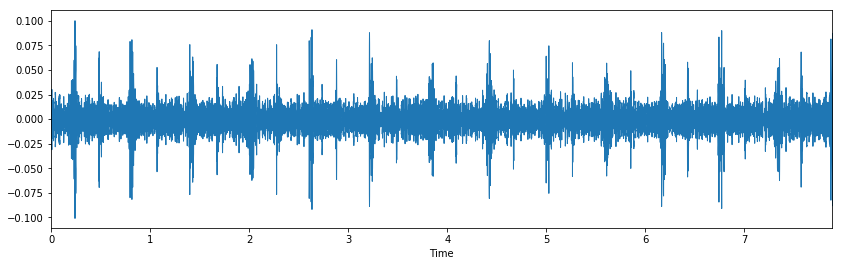

In [63]:
import librosa.display
librosa.display.waveplot(data, fs)

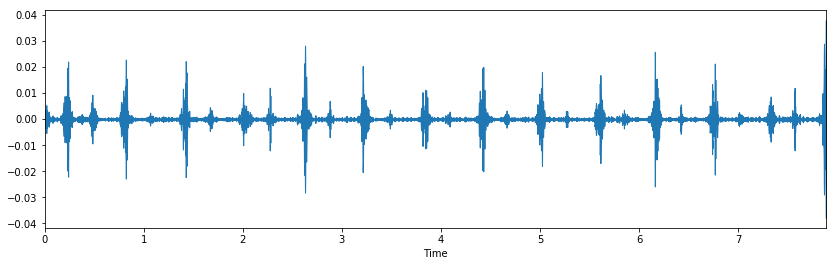

In [64]:
librosa.display.waveplot(x, fs)

In [67]:
#librosa functionality to detect peaks
onset_frames = librosa.onset.onset_detect(x, sr=fs, delta=0.04, wait=4)
onset_times = librosa.frames_to_time(onset_frames, sr=fs)
onset_samples = librosa.frames_to_samples(onset_frames)

In [68]:
def extract_features(x, fs):
    zcr = librosa.zero_crossings(x).sum()
    energy = scipy.linalg.norm(x)
    return [zcr, energy]

In [69]:
frame_sz = fs*0.090
features = numpy.array([extract_features(x[int(i):int(i+frame_sz)], fs) for i in onset_samples])
print(features.shape)

(77, 2)


In [70]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
print(features_scaled.shape)
print(features_scaled.min(axis=0))
print(features_scaled.max(axis=0))

(77, 2)
[-1. -1.]
[1. 1.]


Text(0,0.5,'Spectral Centroid (scaled)')

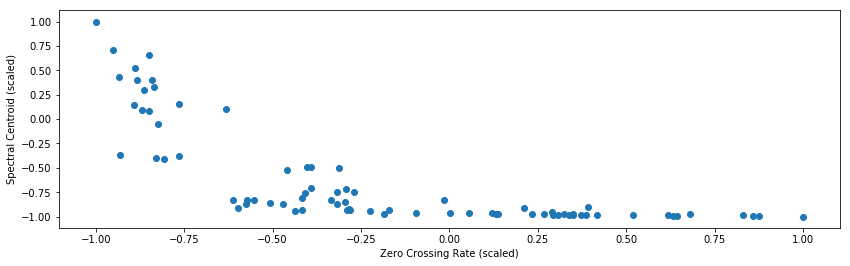

In [71]:
plt.scatter(features_scaled[:,0], features_scaled[:,1])
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Spectral Centroid (scaled)')

In [49]:
model = sklearn.cluster.KMeans(n_clusters=2)
labels = model.fit_predict(features_scaled)
print(labels)

[0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 0 1]


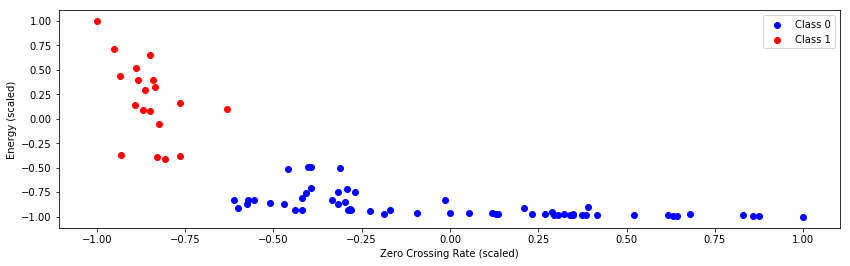

In [50]:
plt.scatter(features_scaled[labels==0,0], features_scaled[labels==0,1], c='b')
plt.scatter(features_scaled[labels==1,0], features_scaled[labels==1,1], c='r')
plt.xlabel('Zero Crossing Rate (scaled)')
plt.ylabel('Energy (scaled)')
plt.legend(('Class 0', 'Class 1'))

In [51]:
#extracting the locations where the peaks for the 2 classes were found
print(onset_samples[labels==0])
print(onset_samples[labels==1])

[  1536  11264  15872  20992  27648  39424  47104  53760  56320  68096
  70656  74240  76800  79360  81920  90624  96768  99840 107008 118784
 123904 126464 132096 152064 159232 177152 180224 182784 186880 196608
 199168 203776 208384 210944 214016 222720 225280 229888 232448 240128
 248320 251392 254464 257536 265216 276992 281600 284672 287744 290304
 292864 304128 308224 315904 328704 334848 339968 342528]
[  7680  32768  60928  87552 112128 115712 139264 165376 167936 191488
 194048 219136 244224 269312 271872 297984 321536 332288 346624]


In [52]:
s1_vl=onset_samples[labels==0]
s2_vl=onset_samples[labels==1]
s1_v=s1_vl.tolist()
s2_v=s2_vl.tolist()

In [53]:
#Extracts the window of the probable S1 and S2 values
val_list=list()
val_list.append(s1_v[0])
val_list.append(s2_v[0])
it=0
count=0
tm=0
for i in range(0,1000):
    if(tm!=s2_v[len(s2_v)-1]):
        if(count==0):
            for i in range(len(s1_v)):
                temp=val_list[len(val_list)-1]
                ind=s2_v.index(temp)
                if(s1_v[i]<s2_v[ind+1]):
                    tm=s1_v[i]
                else:
                    val_list.append(tm)
                    count=1
                    break
        else:
            for i in range(len(s2_v)):
                temp=val_list[len(val_list)-1]
                ind=s1_v.index(temp)
                if(s2_v[i]<s1_v[ind+1]):
                    tm=s2_v[i]
                else:
                    val_list.append(tm)
                    count=0
                    break
    else:
        print("Ending")
        break
print(val_list)

[1536, 7680, 27648, 32768, 56320, 60928, 81920, 87552, 107008, 115712, 132096, 139264, 159232, 167936, 186880, 194048, 214016, 219136, 240128, 244224, 265216, 271872, 292864, 297984, 315904, 321536, 328704, 332288]


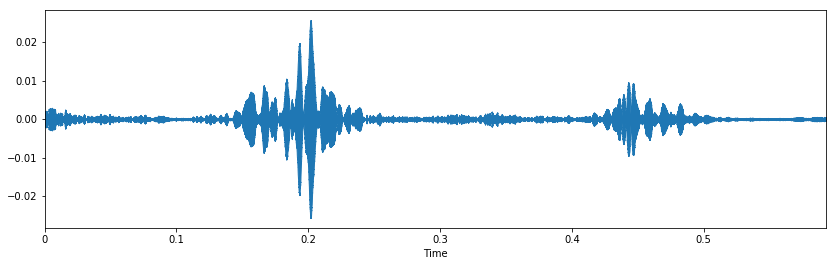

In [66]:
librosa.display.waveplot(x[1536:27680], fs)

In [65]:
#Discards a cycle if the value of interval of S1>S2
S1=0
S2=0
for i in range(0,len(val_list)-2,2):
    if(val_list[i]>val_list[i+1] or val_list[i+1]>val_list[i+2]):
        print("Skip cycle")
    else:
        S1=x[val_list[i]:val_list[i+1]]
        print(val_list[i],end=" ")
        print(val_list[i+1],end=" ")
        print(val_list[i+2])
        S2=x[val_list[i+1]:val_list[i+2]]

1536 7680 27648
27648 32768 56320
56320 60928 81920
81920 87552 107008
107008 115712 132096
132096 139264 159232
159232 167936 186880
186880 194048 214016
214016 219136 240128
240128 244224 265216
265216 271872 292864
292864 297984 315904
315904 321536 328704
